In [1]:
!pip install seaborn==0.9.0
!pip install statsmodels==0.9.0
!pip install tensorflow==1.12.0

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

### Importing Data and Data Cleaning

In [26]:
df = pd.read_csv('./all_stocks_5yr.csv')

In [27]:
df.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [28]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [29]:
open_mean = df["open"].mean()
high_mean = df["high"].mean()
low_mean = df["low"].mean()

In [30]:
df["open"] = df["open"].replace(np.NaN,open_mean)
df["high"] = df["high"].replace(np.NaN,high_mean)
df["low"] = df["low"].replace(np.NaN,low_mean)

In [31]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [32]:
df['average'] = (df['high']+ df['low'])/2
df.head()

,date,open,high,low,close,volume,Name,average
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,14.875
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,14.635
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,14.305
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,14.595
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,14.060


In [33]:
df_amzn = df.query('Name == "AMZN"')
df_amzn = df_amzn.reset_index()
df_amzn = df_amzn.drop(columns ='index')
df_amzn.head()

,date,open,high,low,close,volume,Name,average
0,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN,262.9025
1,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN,259.9250
2,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN,258.5800
3,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN,265.1300
4,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN,268.0250


In [34]:
type(df_amzn['date'].values[0])

str

In [35]:
df_amzn['date'] = pd.to_datetime(df['date'])

In [36]:
type(df_amzn['date'].values[0])

numpy.datetime64

### Exploratory Data Analysis

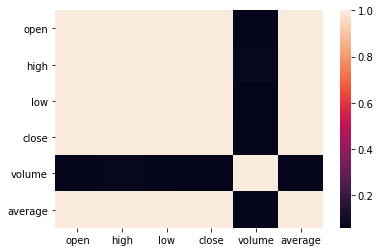

In [37]:
corr = df_amzn.corr(method="pearson")
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

In [53]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('bjornjee','N0K61OHf6DhdYkzr5F1U')

trace = go.Ohlc(x=df_amzn['date'],
                open=df_amzn['open'],
                high=df_amzn['high'],
                low=df_amzn['low'],
                close=df_amzn['close'])
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~bjornjee/0 or inside your plot.ly account where it is named 'simple_candlestick'


/Users/bjornjee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



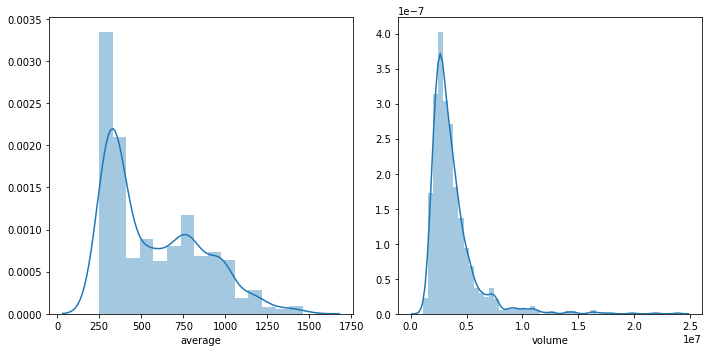

In [39]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.distplot(df_amzn['average'],ax=ax[0])
sns.distplot(df_amzn['volume'],ax=ax[1])
plt.tight_layout()

/Users/bjornjee/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



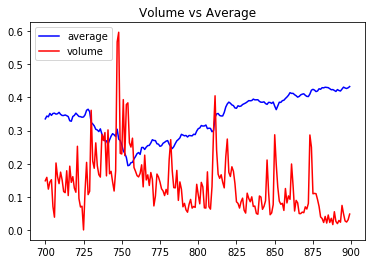

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

ave_norm = scaler.fit_transform(df_amzn['average'].values.reshape(-1,1)).reshape(-1)
vol_norm = scaler.fit_transform((df_amzn['volume'].values.reshape(-1,1))).reshape(-1)

x = np.arange(len(ave_norm))
y = df_amzn['date']

plt.plot(x[700:900],ave_norm[700:900],'b', label='average')
plt.plot(x[700:900], vol_norm[700:900],'r',label='volume')
plt.legend(loc='upper left')
plt.title('Volume vs Average')
None

### Data preprocessing for ARIMA model

This code is a class for Stationarity Test, in particular, we used Augmented-Dickey Fuller Test, which uses AIC to test for Stationarity.

In [41]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
class StationarityTests:
    def __init__(self,significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_StationarityTest(self,timeseries,printResults = True):
        adfTest = adfuller(timeseries, autolag = 'AIC')
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','#Lags Used','#Observations Used'])
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Result')
            print(dfResults)
            print('isStationary: (%s)' %self.isStationary)

In [42]:
sTest = StationarityTests()
sTest.ADF_StationarityTest(df_amzn["average"])

Augmented Dickey-Fuller Test Result
ADF Test Statistic         2.769535
P-Value                    1.000000
#Lags Used                 3.000000
#Observations Used      1255.000000
Critical Value (1%)       -3.435571
Critical Value (5%)       -2.863846
Critical Value (10%)      -2.567998
dtype: float64
isStationary: (False)


We observed that the dataset for Amazon's 'average' prices are not stationary and transformed the data by using differencing, and tidying it up by dropping all NaN values.

In [43]:
df_amzn["average"] = df_amzn["average"].shift(1) - df_amzn["average"]
df_amzn.replace(["NaT","NaN"],np.nan,inplace=True)
df_amzn = df_amzn.dropna()
df_amzn.isnull().sum()
df_amzn.head()

,date,open,high,low,close,volume,Name,average
1,2013-02-11,263.20,263.25,256.60,257.21,3403403,AMZN,2.9775
2,2013-02-12,259.19,260.16,257.00,258.70,2938660,AMZN,1.3450
3,2013-02-13,261.53,269.96,260.30,269.47,5292996,AMZN,-6.5500
4,2013-02-14,267.37,270.65,265.40,269.24,3462780,AMZN,-2.8950
5,2013-02-15,267.63,268.92,263.11,265.09,3979832,AMZN,2.0100


In [44]:
sTest = StationarityTests()
sTest.ADF_StationarityTest(df_amzn["average"])

Augmented Dickey-Fuller Test Result
ADF Test Statistic       -20.709402
P-Value                    0.000000
#Lags Used                 2.000000
#Observations Used      1255.000000
Critical Value (1%)       -3.435571
Critical Value (5%)       -2.863846
Critical Value (10%)      -2.567998
dtype: float64
isStationary: (True)


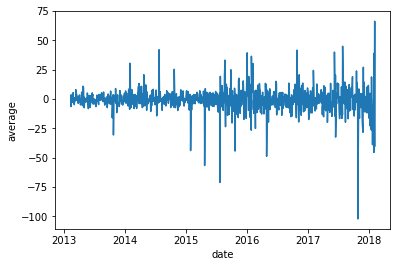

In [45]:
df_amzn.columns.values
df_amzn.head()
sns.lineplot(x='date',y='average',data = df_amzn)

### Feature Selection for Lag Variables

Now that the data is stationary (mean and variance are almost constant), we will check for the auto correlation for ti, tj, i!=j.

/Users/bjornjee/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



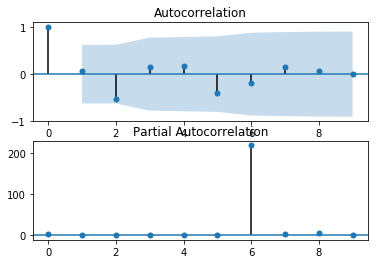

In [46]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(df_amzn["average"][:10], ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(df_amzn["average"][:10], ax=pyplot.gca())
pyplot.show()

In [47]:
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = np.inf, None
  n = len(dataset)
  for p in p_values:
    for d in d_values:
      for q in q_values:
        if p==0 and d==0 and q==0:
          continue
        order = (p,d,q)
        try:
          model = ARIMA(dataset, order)
          model_fit = model.fit(disp=0)
          y_pred = model_fit.predict(n-50,n-1)
          y_true = dataset[n-50:]
          rmse = sqrt(mean_squared_error(y_true,y_pred))
          if rmse < best_score:
            best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 5)
d_values = range(1, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(df_amzn['average'].values, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=19.837
Best ARIMA(0, 1, 0) RMSE=19.837


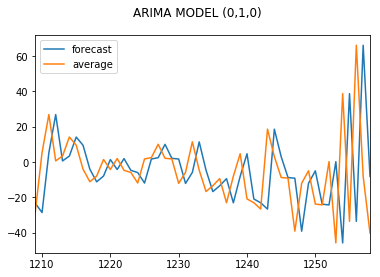

In [48]:
model = ARIMA(df_amzn['average'],(0,1,0))
model_fit = model.fit(disp=0)
n = df_amzn['average'].size
fig = model_fit.plot_predict(n-50)
fig.suptitle('ARIMA MODEL (0,1,0)')
None

In [49]:
model1 =ARIMA(df_amzn["average"], order=(1,1,0))
model2 =ARIMA(df_amzn["average"],order=(1,1,1))
model3 = ARIMA(df_amzn["average"],order=(0,1,1))
model1_fit = model1.fit(disp=0)
model2_fit = model2.fit(disp=0)
model3_fit = model3.fit(disp=0)

print(model_fit.summary())
print()
print()
print(model3_fit.summary())
print()
print()
print(model1_fit.summary())
print()
print()
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.average   No. Observations:                 1257
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4946.347
Method:                           css   S.D. of innovations             12.380
Date:                Wed, 10 Apr 2019   AIC                           9896.694
Time:                        13:39:23   BIC                           9906.967
Sample:                             1   HQIC                          9900.555
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0343      0.349     -0.098      0.922      -0.719       0.650


                             ARIMA Model Results                              
Dep. Variable:              D.average   No. Observ

Plotting the predicted values vs true values for the last 50 days of the dataset

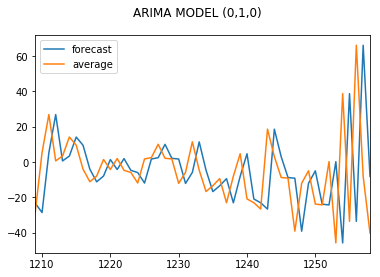

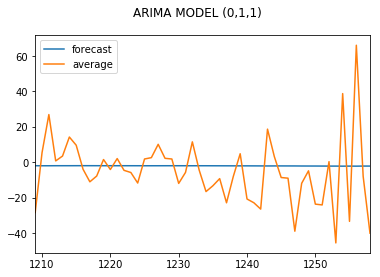

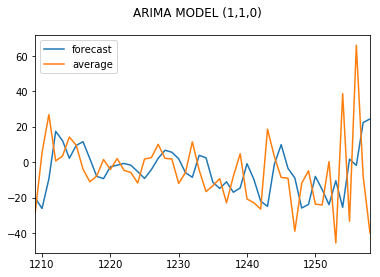

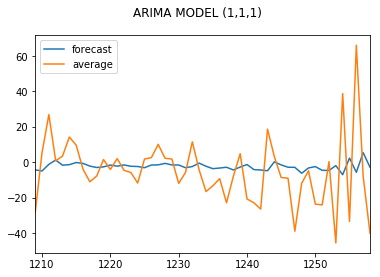

In [50]:
n = df_amzn['average'].size
a = model_fit.plot_predict(n-50)
a.suptitle('ARIMA MODEL (0,1,0)')
d = model3_fit.plot_predict(n-50)
d.suptitle('ARIMA MODEL (0,1,1)')
b = model1_fit.plot_predict(n-50)
b.suptitle('ARIMA MODEL (1,1,0)')
c = model2_fit.plot_predict(n-50)
c.suptitle('ARIMA MODEL (1,1,1)')
None

###Evaluation of our ARIMA models

In [51]:
from sklearn.metrics import r2_score
models = [model_fit,model3_fit,model1_fit,model2_fit]
model_name = ['(0,1,0)','(0,1,1)','(1,1,0)','(1,1,1)']
y_true = df_amzn['average'][n-50:]
r = []
m = []
for model in models:
  y_pred = model.predict(n-50)
  r.append(r2_score(y_true,y_pred))
  m.append(mean_squared_error(y_true,y_pred))
d = {'Model':model_name,'R2 Score':r,'Mean Squared Error':m}
results = pd.DataFrame(data = d)
results[['Model','R2 Score','Mean Squared Error']]

,Model,R2 Score,Mean Squared Error
0,"(0,1,0)",-0.075370,393.509181
1,"(0,1,1)",-0.813881,663.751945
2,"(1,1,0)",-0.253245,458.598813
3,"(1,1,1)",-0.635375,598.431359


### Data Preprocessing for LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [29]:
dataset = df.query('Name == "AMZN"')
dataset = dataset.reset_index()
dataset = dataset.drop(columns='index')
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.head()

,date,open,high,low,close,volume,Name,average
0,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN,262.9025
1,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN,259.9250
2,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN,258.5800
3,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN,265.1300
4,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN,268.0250


We will use the volume of the stock from the past 50 days to predict the average price of the Amazon stock

In [30]:
input_feature = dataset.iloc[:,[5,7,0]].values
input_data = input_feature
input_data[:5]

array([[3879078, 262.90250000000003, Timestamp('2013-02-08 00:00:00')],
       [3403403, 259.925, Timestamp('2013-02-11 00:00:00')],
       [2938660, 258.58000000000004, Timestamp('2013-02-12 00:00:00')],
       [5292996, 265.13, Timestamp('2013-02-13 00:00:00')],
       [3462780, 268.025, Timestamp('2013-02-14 00:00:00')]], dtype=object)

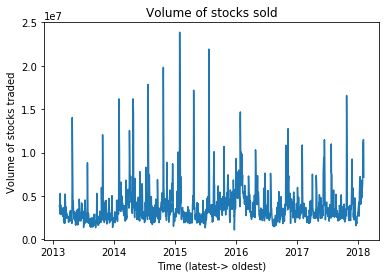

In [31]:
plt.plot(input_feature[:,2],input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()

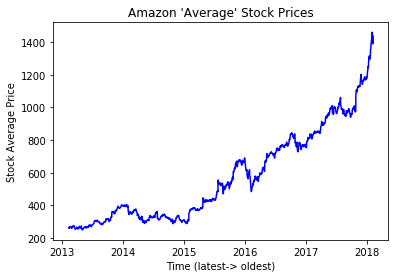

In [32]:
plt.plot(input_feature[:,2],input_feature[:,1], color='blue')
plt.title("Amazon 'Average' Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.show()

Normalizing the data as inputs for the LSTM model.

In [33]:
scaler_ave = MinMaxScaler(feature_range=(0,1))
scaler_vol = MinMaxScaler(feature_range=(0,1))

#print(scaler_vol.fit_transform(input_feature[:,0].reshape(-1,1)).shape)
input_data[:,0] = scaler_vol.fit_transform(input_feature[:,0].reshape(-1,1))[:,0]
input_data[:,1] = scaler_ave.fit_transform(input_feature[:,1].reshape(-1,1))[:,0]
input_data[:5,0:2]

array([[0.1223958610188687, 0.011178220313460496],
       [0.10149909348862568, 0.008721445928272897],
       [0.08108257710179068, 0.0076116687500773494],
       [0.1845103630482505, 0.013016159840918168],
       [0.10410757063298526, 0.015404862391755425]], dtype=object)

The X array will store the volume and price of a sliding window of 50 days, while the y array will store the target value of the opening price for the 51st day for each sample in the X array.

In [ ]:
lookback = 50
X=[]
y=[]
for i in range(len(dataset['open'])-lookback-1):
    t=input_data[i:i+lookback,0:2]
    X.append(t)
    y.append(input_data[i+ lookback,1])

Creation of the train and test datasets. We need to reshape the train data into LSTM expected structure of (samples,timestamp,features)

In [35]:
train_size=int(.7 * len(X))
X, y= np.array(X), np.array(y)
X_train = X[:train_size]
Y_train = y[:train_size]
X_test = X[train_size+lookback+1:]
Y_test = y[train_size+lookback+1:]
X_train = X_train.reshape(X_train.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X_train.shape)
print(X_test.shape)

(845, 50, 2)
(312, 50, 2)


### Training LSTM model

In [36]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 30)            3960      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

We train with 200 epochs, and a batch size of 32 which are commonly used values for LSTM models

In [38]:
model.fit(X_train, Y_train, epochs=200, batch_size=32)

Epoch 1/200
845/845 [==============================] - 4s 5ms/step - loss: 0.0122
Epoch 2/200
845/845 [==============================] - 3s 3ms/step - loss: 8.8873e-04
Epoch 3/200
845/845 [==============================] - 3s 3ms/step - loss: 4.8463e-04
Epoch 4/200
845/845 [==============================] - 3s 3ms/step - loss: 4.2143e-04
Epoch 5/200
845/845 [==============================] - 3s 3ms/step - loss: 3.9664e-04
Epoch 6/200
845/845 [==============================] - 3s 3ms/step - loss: 3.8034e-04
Epoch 7/200
845/845 [==============================] - 3s 3ms/step - loss: 3.7639e-04
Epoch 8/200
845/845 [==============================] - 3s 3ms/step - loss: 3.5435e-04
Epoch 9/200
845/845 [==============================] - 3s 3ms/step - loss: 3.3090e-04
Epoch 10/200
845/845 [==============================] - 3s 3ms/step - loss: 3.1292e-04
Epoch 11/200
845/845 [==============================] - 3s 4ms/step - loss: 3.0877e-04
Epoch 12/200
845/845 [==============================] - 

###Evaluation of LSTM model

In [ ]:
predicted_value= model.predict(X_test)

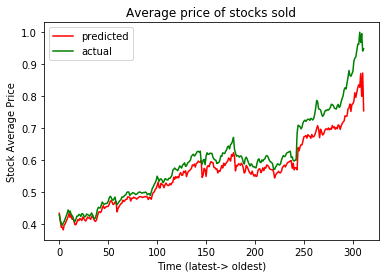

In [40]:
plt.plot(predicted_value, color= 'red', label='predicted')
plt.plot(Y_test, color='green',label = 'actual')
plt.title("Average price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.legend(loc='upper left')
plt.show()

In [41]:
predicted_value.shape
y_predict = predicted_value.reshape(predicted_value.shape[0])
print(y_predict.shape)
print(Y_test.shape)

(312,)
(312,)


Tesing our model using different metrics

In [42]:
d = {'Model':'LSTM','R2 Score':[r2_score(Y_test,y_predict)],'Mean Squared Error':[mean_squared_error(Y_test,y_predict)]}
results = pd.DataFrame(data = d)
results[['Model','R2 Score','Mean Squared Error']]

,Model,R2 Score,Mean Squared Error
0,LSTM,0.872484,0.002138


In [43]:
data_size = len(input_data[:,0])
test_data = input_data[data_size-50:,:2]
test_data = test_data.reshape(1,50,2)
out = model.predict(test_data)
#print(out)
out_inv = scaler_ave.inverse_transform(out)
#print(out_inv)
print('last date: ' + input_data[n-1,2].strftime('%d-%m-%Y'))
print('predicted price for 07-02-2018 :%f'%out_inv[0])

last date: 06-02-2018
predicted price for 07-02-2018 :1268.383057
